In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [159]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,RandomFlip,Rescaling,Resizing,RandomRotation,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import pandas as pd
import seaborn as sbn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

%matplotlib inline

In [3]:
train_dir = pathlib.Path('data/Train')

In [4]:
# class distribution
def Count_images(path):
    folder_image_count = {}
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        
        # Ensure it's a directory (to skip any non-folder files)
        if os.path.isdir(folder_path):
            # Count the number of image files in this folder
            image_count = len([file for file in os.listdir(folder_path) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))])
            folder_image_count[folder_name] = image_count


    for folder, count in folder_image_count.items():
        print(f"Folder '{folder}' has {count} images.")

In [5]:
Count_images(train_dir)

Folder 'American Bollworm on Cotton' has 56 images.
Folder 'Anthracnose on Cotton' has 29 images.
Folder 'Army worm' has 39 images.
Folder 'bacterial_blight in Cotton' has 489 images.
Folder 'Becterial Blight in Rice' has 1584 images.
Folder 'bollworm on Cotton' has 21 images.
Folder 'Brownspot' has 1640 images.
Folder 'Common_Rust' has 1303 images.
Folder 'Cotton Aphid' has 38 images.
Folder 'cotton mealy bug' has 90 images.
Folder 'cotton whitefly' has 54 images.
Folder 'Flag Smut' has 179 images.
Folder 'Gray_Leaf_Spot' has 574 images.
Folder 'Healthy cotton' has 425 images.
Folder 'Healthy Maize' has 1162 images.
Folder 'Healthy Wheat' has 180 images.
Folder 'Leaf Curl' has 417 images.
Folder 'Leaf smut' has 40 images.
Folder 'maize ear rot' has 112 images.
Folder 'maize fall armyworm' has 107 images.
Folder 'maize stem borer' has 95 images.
Folder 'Mosaic sugarcane' has 462 images.
Folder 'pink bollworm in cotton' has 24 images.
Folder 'red cotton bug' has 69 images.
Folder 'RedRo

In [6]:
# checking for corrupt files
def Check_for_corrupt_files(path):
    for root, dirs, files in os.walk(path):
     for file in files:
        try:
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                img.verify() 
            return False
        except (IOError, SyntaxError) as e:
            print(f"Corrupt file found and removed: {img_path}")
            os.remove(img_path)
            return True

In [7]:
#main preprocessing directories images
import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext




In [8]:
# 
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(train_dir, good_exts)

if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  American Bollworm on Cotton
processing class directory  Anthracnose on Cotton
processing class directory  Army worm
processing class directory  bacterial_blight in Cotton
processing class directory  Becterial Blight in Rice
processing class directory  bollworm on Cotton
processing class directory  Brownspot
processing class directory  Common_Rust
processing class directory  Cotton Aphid
processing class directory  cotton mealy bug
processing class directory  cotton whitefly
processing class directory  Flag Smut
processing class directory  Gray_Leaf_Spot
processing class directory  Healthy cotton
processing class directory  Healthy Maize
processing class directory  Healthy Wheat
processing class directory  Leaf Curl
processing class directory  Leaf smut
processing class directory  maize ear rot
processing class directory  maize fall armyworm
processing class directory  maize stem borer
processing class directory  Mosaic sugarcane
processing class directory  p

In [9]:
for file_path in bad_file_list:
   if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
   else:
    print(f"{file_path} does not exist.")

In [10]:
# removing corrupt files in train data
Check_for_corrupt_files(train_dir)

False

In [11]:
train_dataset = image_dataset_from_directory(train_dir,
                                             image_size=(224, 224),
                                             batch_size=32,
                                             label_mode="categorical",
                                             validation_split=0.2,    
                                             subset="training",
                                             seed=123
                                            )


Found 15291 files belonging to 41 classes.
Using 12233 files for training.


In [12]:
validation_dataset = image_dataset_from_directory(train_dir,
                                                  image_size=(224,224),
                                                  batch_size=32,
                                                  label_mode="categorical",
                                                  validation_split=0.2,    
                                                  subset="validation",
                                                  seed=123
                                                 )

Found 15291 files belonging to 41 classes.
Using 3058 files for validation.


In [13]:
# creating test data for evaluating the model

val_images,val_labels = zip(*[(x,y) for x,y in validation_dataset.unbatch()])
val_images,test_images,val_labels,test_labels = train_test_split(val_images,val_labels,test_size=0.5,random_state=42);

new_validation_dataset = tf.data.Dataset.from_tensor_slices((val_images,val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(32)

In [14]:
print(f"new validation dataset length {len(new_validation_dataset)} and test data length {len(test_dataset)}")

new validation dataset length 48 and test data length 48


In [15]:
class_names=train_dataset.class_names

In [16]:
def Plot_images(dataset,num):
    plt.figure(figsize=(10,10))
    for images,labels in dataset.take(1):
        for i in range(num):
            ax = plt.subplot(3, 3 ,i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # print(np.argmax(labels[i]))
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")
        plt.show()

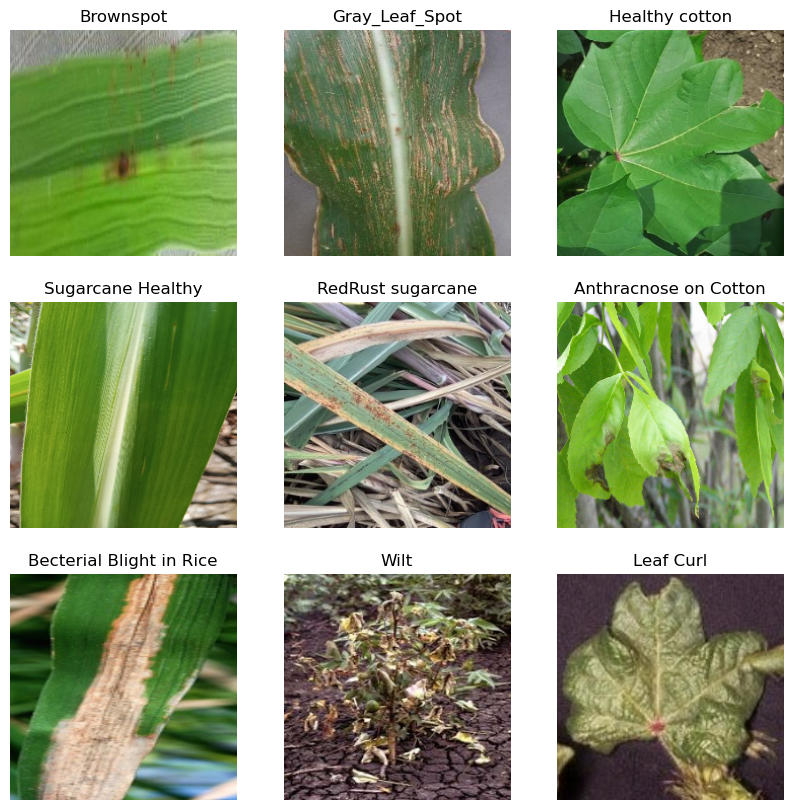

In [17]:
Plot_images(train_dataset,9)

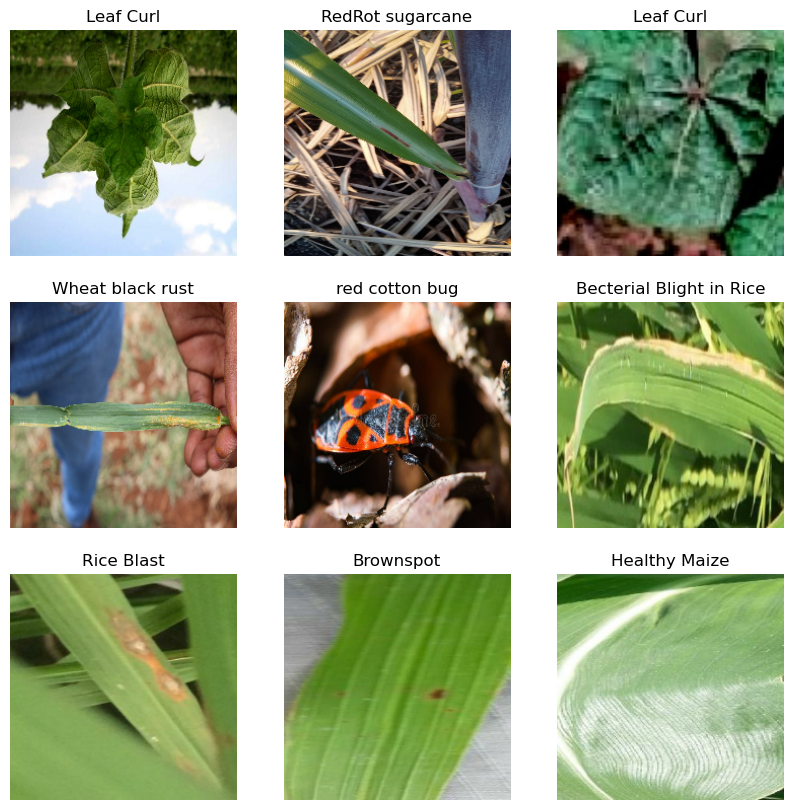

In [18]:
# validation dataset
Plot_images(validation_dataset,9)

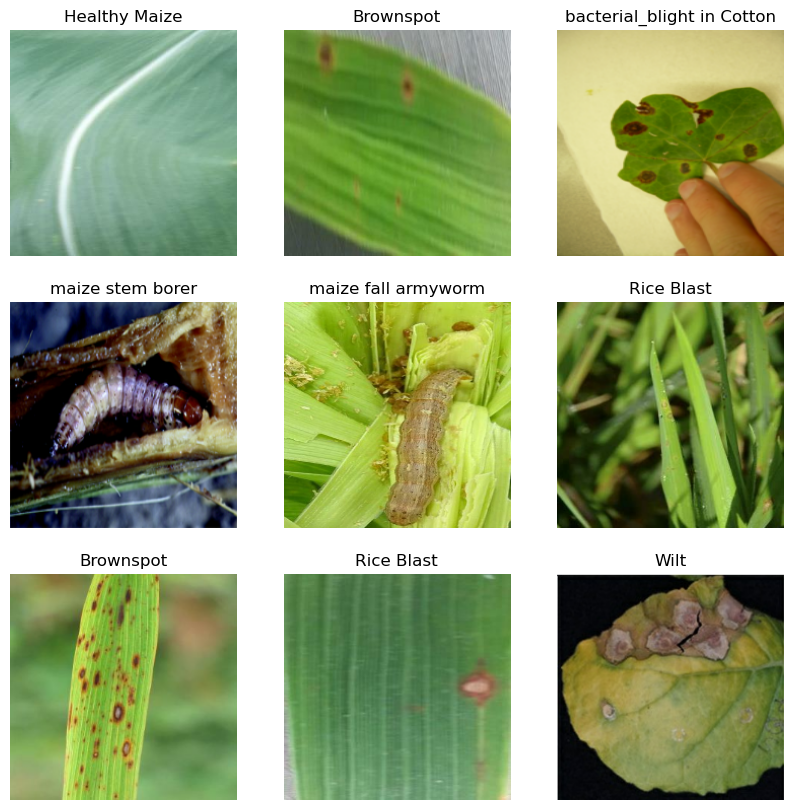

In [19]:
Plot_images(test_dataset,9)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
num_classes = len(class_names)
Batch_size=32

image_height=224
image_width=224

input_shape=(Batch_size,image_height,image_width,3)

model = Sequential()

model.add(Resizing(image_height,image_width))
model.add(Rescaling(1.0/255))
model.add(RandomFlip('horizontal_and_vertical'))
model.add(RandomRotation(0.2))
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 224, 224, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 224, 224, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 224, 224, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                      

In [23]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[ 'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

In [24]:
model_history = model.fit(train_dataset,
                    epochs=15,
                    steps_per_epoch=len(train_dataset),
                    batch_size=32,
                    validation_data=validation_dataset,
                    validation_steps=len(validation_dataset))

Epoch 1/15
383/383 [==============================] - 313s 706ms/step - loss: 2.1863 - accuracy: 0.4102 - precision: 0.7856 - recall: 0.2250 - val_loss: 1.9024 - val_accuracy: 0.4990 - val_precision: 0.8519 - val_recall: 0.2371
Epoch 2/15
383/383 [==============================] - 266s 695ms/step - loss: 1.4233 - accuracy: 0.6152 - precision: 0.8240 - recall: 0.4790 - val_loss: 1.3457 - val_accuracy: 0.6540 - val_precision: 0.8547 - val_recall: 0.4771
Epoch 3/15
383/383 [==============================] - 287s 749ms/step - loss: 1.0960 - accuracy: 0.7064 - precision: 0.8539 - recall: 0.5999 - val_loss: 1.0184 - val_accuracy: 0.7312 - val_precision: 0.8650 - val_recall: 0.6308
Epoch 4/15
383/383 [==============================] - 280s 731ms/step - loss: 0.8720 - accuracy: 0.7620 - precision: 0.8766 - recall: 0.6828 - val_loss: 1.1118 - val_accuracy: 0.7041 - val_precision: 0.8007 - val_recall: 0.6530
Epoch 5/15
383/383 [==============================] - 284s 742ms/step - loss: 0.7463 - a

In [25]:
# normalizing the test data for prediction
normalization_layer = Rescaling(1./255)
normalized_test_data = test_dataset.map(lambda x,y:(normalization_layer(x),y))

image_batch,label_batch = next(iter(normalized_test_data))

image = image_batch[1]

print(np.min(image),np.max(image))

0.05960479 0.8126318


In [43]:
X_test = []
y_test = []

for images, labels in test_dataset:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [44]:
y_pred = model.predict(X_test)

48/48 [==============================] - 5s 107ms/step


In [64]:
X_test.shape,y_test.shape

((1529, 224, 224, 3), (1529, 41))

In [174]:
def predict_disease(index):
    plt.imshow(X_test[index].astype(np.uint8))
    plt.title(f"model predicted as {class_names[np.argmax(y_pred[index])]} \n actual Label {class_names[np.argmax(y_test[index])]} \n confidence {round(100 * np.max(y_pred[index]),2)}")
    plt.axis("off")
    plt.show()

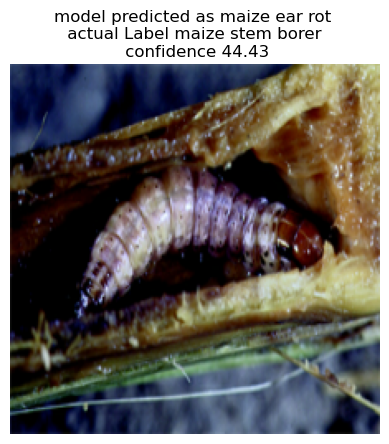

In [177]:
predict_disease(3)

In [134]:
model.evaluate(test_dataset)

48/48 [==============================] - 6s 115ms/step - loss: 0.7807 - accuracy: 0.8169 - precision: 0.8763 - recall: 0.7874


[0.7807379364967346,
 0.8168737888336182,
 0.8762736320495605,
 0.7874427437782288]

In [125]:
model_performance=pd.DataFrame(model_history.history)

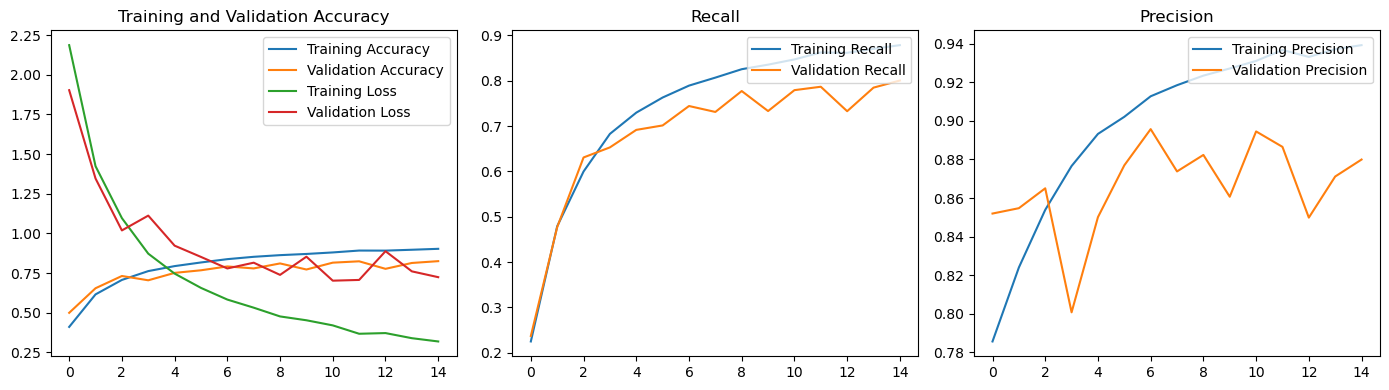

In [126]:
epochs_range = range(15)
fig, axes = plt.subplots(1, 3, figsize=(14,4))

# First row, first plot
axes[0].plot(epochs_range, model_performance['accuracy'], label='Training Accuracy')
axes[0].plot(epochs_range, model_performance['val_accuracy'], label='Validation Accuracy')
axes[0].plot(epochs_range, model_performance['loss'], label='Training Loss')
axes[0].plot(epochs_range, model_performance['val_loss'], label='Validation Loss')
axes[0].legend(loc='upper right')
axes[0].set_title('Training and Validation Accuracy')

axes[1].plot(epochs_range, model_performance['recall'], label='Training Recall')
axes[1].plot(epochs_range, model_performance['val_recall'], label='Validation Recall')
axes[1].legend(loc='upper right')
axes[1].set_title('Recall')

axes[2].plot(epochs_range, model_performance['precision'], label='Training Precision')
axes[2].plot(epochs_range, model_performance['val_precision'], label='Validation Precision')
axes[2].legend(loc='upper right')
axes[2].set_title('Precision')

plt.tight_layout()
plt.show()

In [156]:
predicted_classes =np.argmax(y_pred,axis=1)
true_classes = np.argmax(y_test, axis=1) 

predicted_classes.shape,true_classes.shape

all_labels = list(range(len(class_names)))
len(np.unique(predicted_classes))

len(np.unique(true_classes))
report= classification_report(true_classes,predicted_classes,target_names=class_names,labels=all_labels,zero_division=0)

print(report)

                             precision    recall  f1-score   support

American Bollworm on Cotton       0.00      0.00      0.00         8
      Anthracnose on Cotton       0.00      0.00      0.00         4
                  Army worm       0.00      0.00      0.00         3
   Becterial Blight in Rice       0.93      0.95      0.94       147
                  Brownspot       0.99      0.97      0.98       166
                Common_Rust       0.97      0.92      0.95       145
               Cotton Aphid       0.00      0.00      0.00         1
                  Flag Smut       0.67      0.73      0.70        22
             Gray_Leaf_Spot       0.72      0.82      0.77        57
              Healthy Maize       0.97      0.99      0.98       114
              Healthy Wheat       1.00      0.79      0.88        19
             Healthy cotton       0.97      0.68      0.80        44
                  Leaf Curl       0.88      0.90      0.89        39
                  Leaf smut      

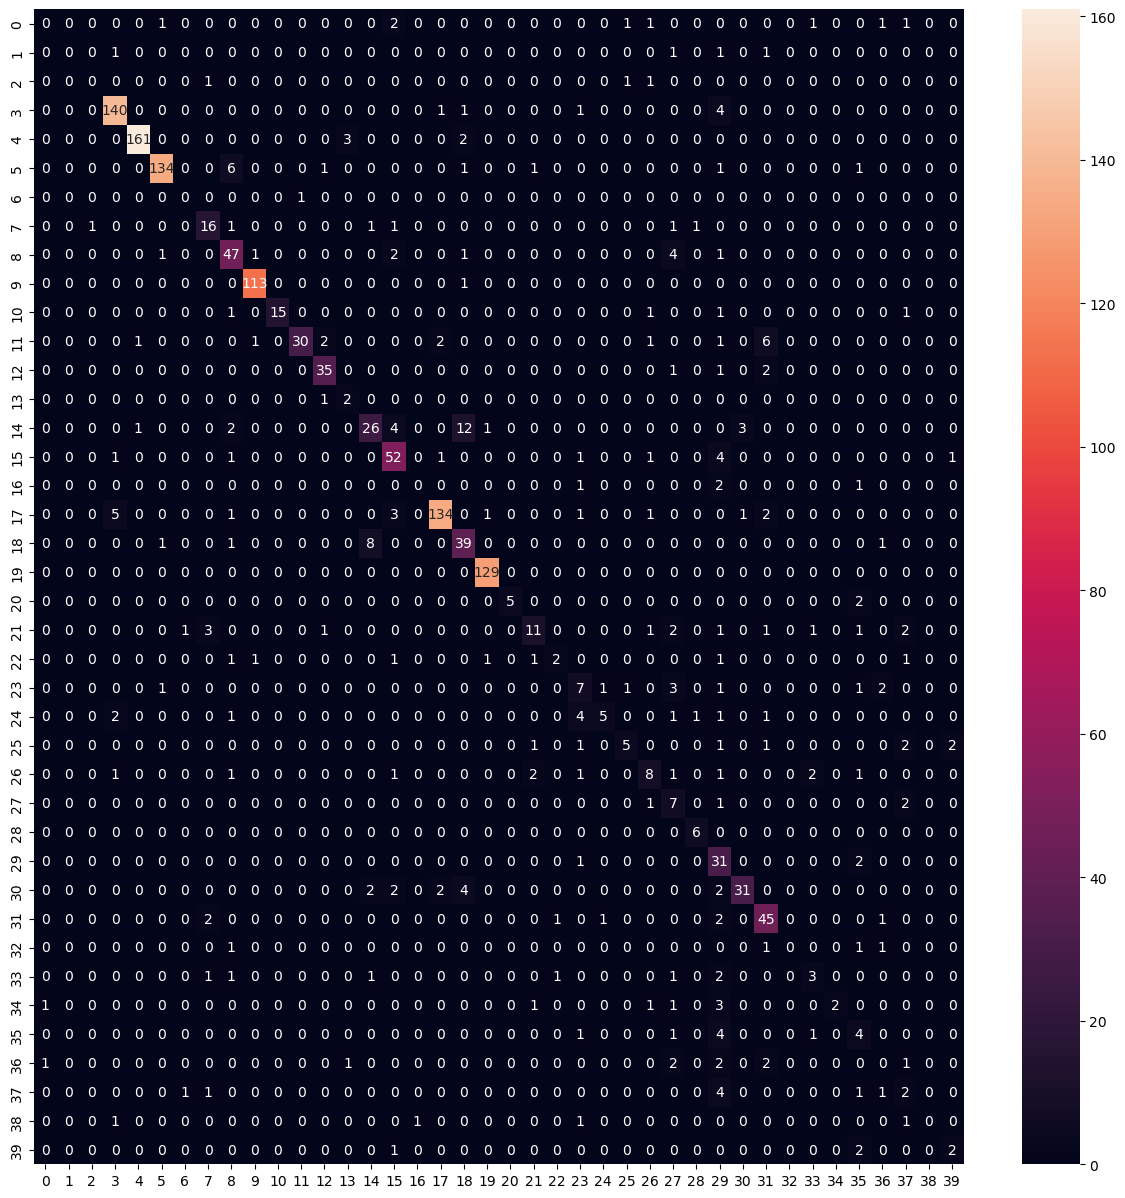

In [165]:
matrix = confusion_matrix(true_classes,predicted_classes)

plt.figure(figsize=(15,15))
sbn.heatmap(data=matrix,annot=True,fmt='d')
plt.show()

In [179]:
# saving model
model_version = 1

model.save(f"./models/model/v{model_version}")

INFO:tensorflow:Assets written to: ./models/model/v1\assets


INFO:tensorflow:Assets written to: ./models/model/v1\assets
